In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/who-is-the-real-winner/sample_submission.csv
/kaggle/input/who-is-the-real-winner/train.csv
/kaggle/input/who-is-the-real-winner/test.csv


In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier

In [3]:
test_file_path = '/kaggle/input/who-is-the-real-winner/test.csv'
train_file_path = '/kaggle/input/who-is-the-real-winner/train.csv'

In [4]:
train_data=pd.read_csv(train_file_path)
test_data=pd.read_csv(test_file_path)

In [5]:
train_y=train_data.Education
features = ['Party','Criminal Case','Total Assets','Liabilities','state']
train_X = train_data[features].copy()
test_X = test_data[features].copy()

In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for col in ['Party', 'state']:
    train_X[col] = label_encoder.fit_transform(train_X[col])
    test_X[col] = label_encoder.transform(test_data[col])

In [7]:
def convert_to_lacks(value):
    if not isinstance(value, str):
        value = str(value)
    if isinstance(value, str):
        if 'Crore' in value:
            return float(value.replace(' Crore+', ''))*100
        elif 'Lac' in value:
            return float(value.replace(' Lac+', ''))
        elif 'Thou' in value:
            return float(value.replace(' Thou+', '')) / 100
        elif 'Hund' in value:
            return float(value.replace(' Hund+', ''))/1000
        else:
            return float(value) / 100000
    return value/100000

In [8]:
for col in ['Total Assets', 'Liabilities']:
    train_X[col] = train_X[col].apply(convert_to_lacks)
    test_X[col] = test_data[col].apply(convert_to_lacks)

In [9]:
def conversion(value):
    if value == '10th Pass':
        return 1
    elif value == '12th Pass':
        return 2
    elif value == '5th Pass':
        return 3
    elif value == '8th Pass':
        return 4
    elif value == 'Doctorate':
        return 5
    elif value == 'Graduate':
        return 6
    elif value == 'Graduate Professional':
        return 7
    elif value == 'Literate':
        return 8
    elif value == 'Others':
        return 9
    elif value == 'Post Graduate':
        return 10


In [10]:
def reverse_conversion(value):
    if value <= 1.5:
        return '10th Pass'
    elif value <= 2.5:
        return '12th Pass'
    elif value <= 3.5:
        return '5th Pass'
    elif value <= 4.5:
        return '8th Pass'
    elif value <= 5.5:
        return 'Doctorate'
    elif value <= 6.5:
        return 'Graduate'
    elif value <= 7.5:
        return 'Graduate Professional'
    elif value <= 8.5:
        return 'Literate'
    elif value <= 9.5:
        return 'Others'
    elif value > 9.5:
        return 'Post Graduate'    

In [11]:
# # model = RandomForestClassifier(n_estimators=10000, random_state=0)
# # model.fit(train_X, train_y)
# # from sklearn.tree import DecisionTreeRegressor
# # from sklearn.metrics import accuracy_score, classification_report
# # max_accuracy=0
# # nodes=0
# # from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
class_weights = {}
total_samples = len(train_y)  # Assuming train_y contains the labels
education_counts = train_y.value_counts()  # Count occurrences of each education level
max_count = education_counts.max()  # Maximum count among all education levels
sum=0
for level, count in education_counts.items():
    class_weights[level] = max_count/count
#     sum=sum+class_weights[level]
# for level, count in education_counts.items():
#     class_weights[level] = class_weights[level]/sum
#     class_weights[level] = 1/class_weights[level]
filtered_train_X = train_X[train_y.map(class_weights) <= 5]
filtered_train_y = train_y[train_y.map(class_weights) <= 5]
# class_weights_filtered = {level: weight for level, weight in class_weights.items() if weight <= 25}
# max_accuracy = 0
# best_model = None
# for n_estimators_value in [10, 20, 30, 40, 50, 100, 200, 500, 1000]:
#     model = RandomForestClassifier(n_estimators=n_estimators_value, random_state=0)
#     train_y=train_y.apply(conversion)
#     model.fit(train_X, train_y)
#     train_prediction = model.predict(train_X)
#     print(train_prediction)
#     train_y=train_y.apply(reverse_conversion)
#     train_prediction = pd.Series(train_prediction)
#     train_prediction=train_prediction.apply(reverse_conversion)
#     accuracy = accuracy_score(train_y, train_prediction)
#     if(accuracy>max_accuracy):
#         max_accuracy=accuracy
#         best_model=model
#     print("Accuracy:", accuracy)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
trainsplit_X, testsplit_X, trainsplit_y, testsplit_y = train_test_split(filtered_train_X, filtered_train_y, test_size = 0.2, random_state=0)
f1_scorer = make_scorer(f1_score, average='weighted')
param_grid = {
    'n_estimators': [5000],
    'max_depth': [None],
    'min_samples_split': [10],
    'min_samples_leaf': [2],
    'bootstrap': [True],
    'class_weight': [class_weights],
    'random_state': [0],
    'oob_score': [True]
}
rf_classifier = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring=f1_scorer)
# grid_search.fit(train_X, train_y)
# grid_search.fit(filtered_train_X, filtered_train_y)
grid_search.fit(trainsplit_X, trainsplit_y)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)

best_model = grid_search.best_estimator_
train_predictions = best_model.predict(train_X)
accuracy = accuracy_score(train_y, train_predictions)
print("Accuracy on training set:", accuracy)


Best parameters: {'bootstrap': True, 'class_weight': {'Graduate': 1.0, 'Post Graduate': 1.2291666666666667, '12th Pass': 1.521489971346705, 'Graduate Professional': 1.5663716814159292, '10th Pass': 2.33920704845815, '8th Pass': 6.8076923076923075, 'Doctorate': 10.211538461538462, 'Others': 18.964285714285715, 'Literate': 37.92857142857143, '5th Pass': 59.0}, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 5000, 'oob_score': True, 'random_state': 0}
Best score: 0.2362202894389191
Accuracy on training set: 0.6454589606605148


In [12]:
train_X.head()

,Party,Criminal Case,Total Assets,Liabilities,state
0,7,4,21100.0,200.0,23
1,4,0,100.0,0.0,13
2,8,0,700.0,22.0,11
3,4,0,900.0,24.0,3
4,4,2,200.0,61.0,27


In [13]:
predictions = best_model.predict(test_X)
print(predictions)

['12th Pass' 'Graduate Professional' 'Graduate' ... 'Post Graduate'
 '12th Pass' 'Post Graduate']


In [14]:
submission_df = pd.DataFrame({'ID': test_data['ID'], 'Education': predictions})
submission_df.to_csv('/kaggle/working/submission.csv', index=False)
submission_df.head()

,ID,Education
0,0,12th Pass
1,1,Graduate Professional
2,2,Graduate
3,3,Post Graduate
4,4,Graduate


In [15]:
# Generate a classification report
# This report includes precision, recall, F1-score, and support for each class
# It provides a more detailed overview of the model's performance
from sklearn.metrics import classification_report
classification_rep = classification_report(train_y, train_predictions)
print("Classification Report:\n", classification_rep)


Classification Report:
                        precision    recall  f1-score   support

            10th Pass       0.65      0.73      0.69       227
            12th Pass       0.62      0.74      0.68       349
             5th Pass       0.00      0.00      0.00         9
             8th Pass       0.00      0.00      0.00        78
            Doctorate       0.00      0.00      0.00        52
             Graduate       0.70      0.64      0.66       531
Graduate Professional       0.59      0.78      0.68       339
             Literate       0.00      0.00      0.00        14
               Others       0.00      0.00      0.00        28
        Post Graduate       0.67      0.69      0.68       432

             accuracy                           0.65      2059
            macro avg       0.32      0.36      0.34      2059
         weighted avg       0.59      0.65      0.62      2059



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


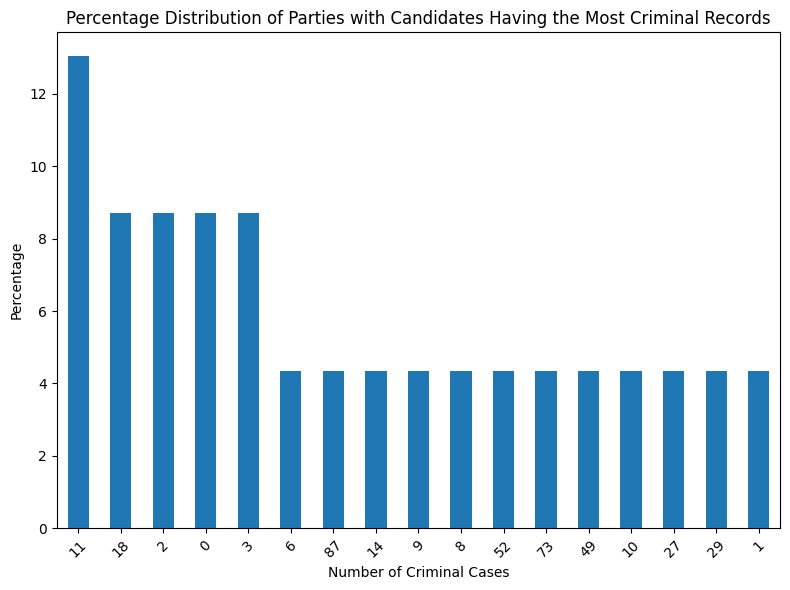

In [19]:
import matplotlib.pyplot as plt

# Calculate percentage distribution of parties with most criminal records
criminal_records_distribution = train_data.groupby('Party')['Criminal Case'].max().value_counts(normalize=True) * 100

# Plot the distribution
plt.figure(figsize=(8, 6))
criminal_records_distribution.plot(kind='bar')
plt.title('Percentage Distribution of Parties with Candidates Having the Most Criminal Records')
plt.xlabel('Number of Criminal Cases')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plot1.png')
plt.show()

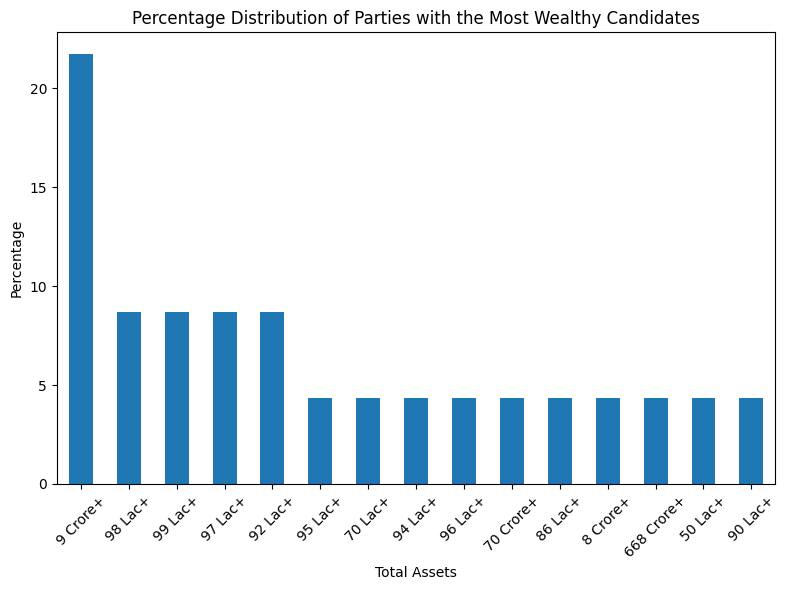

In [20]:
# Calculate percentage distribution of parties with most wealthy candidates
wealthy_candidates_distribution = train_data.groupby('Party')['Total Assets'].max().value_counts(normalize=True) * 100

# Plot the distribution
plt.figure(figsize=(8, 6))
wealthy_candidates_distribution.plot(kind='bar')
plt.title('Percentage Distribution of Parties with the Most Wealthy Candidates')
plt.xlabel('Total Assets')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plot2.png')
plt.show()
